In [1]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.font_manager as fm
fe = fm.FontEntry(
    fname='/nfs/users/nfs_e/er10/fonts/arial.ttf',
    name='my_arial')
fm.fontManager.ttflist.insert(0, fe) # or append is fine
mpl.rcParams['font.family'] = fe.name # = 'your custom ttf font name'
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['text.color'] = 'k'
mpl.rcParams['axes.labelcolor'] = 'k'
mpl.rcParams['xtick.color'] = 'k'
mpl.rcParams['ytick.color'] = 'k'

import seaborn as sns
import pandas as pd
import pysam
from liftover import get_lifter
import tabix
from scipy import stats
from scipy.stats import chisquare
import scikit_posthocs as sp
%matplotlib inline

In [2]:
data_root='/nfs/users/nfs_e/er10/SGE/DDX3X_paper/Revised/'
out_files='/nfs/users/nfs_e/er10/SGE/DDX3X_paper/Figure_plots/'

df=pd.read_csv(data_root+'Table_S9_SGE_data_for_all_variants_tested_with_annotation.txt', header=0, sep='\t',index_col=False)
not_snvre=df.query('Variant_design_type!="snvre"')

In [3]:
def label_true_pos_negs(row):
    pos=row['VCF_position']
    ref=row['VCF_Ref']
    alt=row['VCF_Alt']
    var=(pos, ref, alt)
    if row['Category_for_RF'] == 0:
        label = 'GnomAD/UKBB/Benign'
    else:
        try:
            source=female_denovos[var]
            label = 'LP/P Female denovo'
        except KeyError:
            label=''
    return label

def filter_clinical_vars(row):
    pos=row['hg38_pos']
    ref=row['ref']
    alt=row['alt']
    inh=row['inheritance']
    path=row['pathogenicity']
    sex=row['sex']
    source=row['reported_in']
    if path in ['not_interpreted', 'Pathogenic/Likely_pathogenic']:
        if 'denovo' in inh:
            if 'female' in sex:
                female_denovos[(pos, ref, alt)] = source
                
female_denovos={}

clinical=pd.read_csv(data_root+'Supp_Table13_DDX3X_all_clinical_variants.txt', header=0, sep='\t',index_col=False)

clinical.apply(filter_clinical_vars, axis=1)

df['True_pos_neg'] = df.apply(label_true_pos_negs, axis=1)
true_pos_neg = df.query('True_pos_neg == "LP/P Female denovo" or True_pos_neg =="GnomAD/UKBB/Benign"')

No handles with labels found to put in legend.


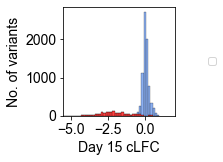

In [13]:
color_dict={1: 'red', 0:'cornflowerblue'}
fig, ax = plt.subplots()
ax.set_xlabel('Day 15 cLFC', fontsize=14)
ax.set_ylabel('No. of variants', fontsize=14)
ax.set_xlim(-5.5,2)
#ax.set_ylim(0,500)
fig.set_size_inches(2,2)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
g=sns.histplot(data=not_snvre, x="D15_combined_LFC", hue='SGE_prediction_of_variant_function_in_NDD_context', palette=color_dict, binwidth=0.15, edgecolor="k", legend=False, multiple='stack', fill=True)
g.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)
plt.savefig(out_files+'/Fig6A_histplot_RF_output.pdf', dpi=1300, bbox_inches='tight', transparent=True)

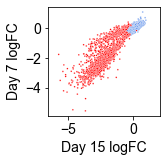

In [14]:
color_dict = {1:'red', 0:'cornflowerblue'}
fig, ax = plt.subplots()
ax.set_xlabel('Day 15 logFC', fontsize=14)
ax.set_ylabel('Day 7 logFC', fontsize=14)
ax.set_xlim(-6.5,2)
fig.set_size_inches(2,2)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
g=sns.scatterplot(data=not_snvre, x='D15_combined_LFC', y='D7_combined_LFC', hue='SGE_prediction_of_variant_function_in_NDD_context', marker='.', palette = color_dict, s=10, legend=False)
plt.savefig(out_files+'/Fig6B_GMMplot_RF_output.pdf', dpi=1300, bbox_inches='tight', transparent=True)


Rationale for in silico variant interpretation and points-based scoring is from Tavtigian et al. 2020:

Posterior probability thresholds:
Pathogenic Posterior Prob > 0.99
Likely pathogenic post prob: 0.9 - 0.99
VUS post prob: 0.1-0.9
Likely benign PP 0.001 - 0.1
Benign PP < 0.001

Evidence Point Scale
Strength      Pathogenic     Benign
Indeterminate   0              0 
Supporting      1              −1
Moderate        2              −2
Strong          4              −4
Very Strong     8              −8

This translates to the following points-based cutoffs:
Category            Point ranges
Pathogenic             ≥ 10
Likely Pathogenic      6 – 9
Uncertain              0 – 5
Likely Benign         −1 – −6
Benign                 ≤ −7

In [7]:
base_pos_to_prot_pos={}
protpos_pos_dict={}
aa_change_dict={}
clinical_pathogenic={}
missense_by_prot_pos={}

# Add to the clinical_pathogenic dictionary all recurrent likely pathogenic / pathogenic denovo variants
with open(data_root+'Recurrent_denovo_clinical_variants.txt', 'r') as f:
    header=f.readline().strip().split('\t')
    pos_col=header.index('hg38_pos')
    ref_col=header.index('ref')
    alt_col = header.index('alt')
    recurrent_col=header.index('Number_of_recurrent')
    lines=f.readlines()
    for line in lines:
        fields=line.strip().split('\t')
        pos=fields[pos_col].strip('""')
        ref=fields[ref_col].strip('""')
        alt=fields[alt_col].strip('""')
        recurrence=fields[recurrent_col].strip()
        clinical_pathogenic[(pos,ref, alt)]=('denovo', recurrence)
        
with open('/nfs/users/nfs_e/er10/SGE/Clinical_variants/DDX3X_all_clinical_variants.txt', 'r')as f:
    header=f.readline().strip().split('\t')
    print(header)
    pos_col=header.index('hg38_pos')
    ref_col=header.index('ref')
    alt_col = header.index('alt')
    prot_pos_col = header.index('Protein_position')
    CDS_pos_col=header.index('CDS_pos')
    refaa_col=header.index('Ref_aa')
    altaa_col=header.index('Alt_aa')
    clin_inh_col=header.index('inheritance')
    clin_path_col=header.index('pathogenicity')
    source_col=header.index('reported_in')
    lines=f.readlines()
    for line in lines:
        fields=line.strip().split('\t')
        pos=fields[pos_col].strip('""').strip()
        ref=fields[ref_col].strip('""').strip()
        alt=fields[alt_col].strip('""').strip()
        prot_pos=fields[prot_pos_col].strip('""').strip()
        CDS_pos=fields[CDS_pos_col].strip('""').strip()
        ref_aa=fields[refaa_col].strip('""').strip()
        alt_aa=fields[altaa_col].strip('""').strip()
        clin_path = fields[clin_path_col].strip('""').strip()
        clin_inh = fields[clin_inh_col].strip('""').strip()
        source=fields[source_col].strip('""').strip()
        # add into the clinical_pathogenic dictionary those non-recurrent denovo variants
        if clin_path == 'Pathogenic/Likely_pathogenic':
            try:
                existing_inh, recurrence = clinical_pathogenic[(pos,ref, alt)]
        
            except KeyError:
                clinical_pathogenic[(pos,ref, alt)] = (clin_inh, 1)
        
        if '-' not in CDS_pos:
            base_pos_to_prot_pos[int(pos)]=prot_pos
            aa_change_dict[int(pos), ref, alt] = ([ref_aa, alt_aa])
            try:
                existing_positions = protpos_pos_dict[int(prot_pos)]
                if (pos, ref) not in existing_positions:
                    out_info=(pos, ref)
                    existing_positions.append(out_info)
                    protpos_pos_dict[int(prot_pos)]=existing_positions
            except KeyError:
                out_info=(pos, ref)
                protpos_pos_dict[int(prot_pos)]=[out_info]

''' Make a dictionary of missense clinical variants indexed by protein position'''
for variant in clinical_pathogenic:
    pos, ref, alt = variant
    inh, recurrence=clinical_pathogenic[(pos, ref, alt)]
    # do not include frameshift variants
    if len(ref) == len(alt):
        try:
            prot_pos = base_pos_to_prot_pos[int(pos)]
            refaa, altaa=aa_change_dict[int(pos), ref, alt]
            # do not include stop-gained variants
            if altaa !='STOP':
                try:
                    existing_vars = missense_by_prot_pos[prot_pos]
                    existing_vars.append([refaa, altaa, pos, ref, alt, inh])
                    missense_by_prot_pos[prot_pos] = existing_vars
                except KeyError:
                    missense_by_prot_pos[prot_pos] = [[refaa, altaa, pos, ref, alt, inh]]
        except KeyError:
            prot_pos = 'NA'


['hg38_pos', 'ref', 'alt', 'reported_in', 'ID', 'inheritance', 'pathogenicity', 'sex', 'SGE_functional_classification', 'Protein_position', 'CDS_pos', 'Ref_aa', 'Alt_aa']


In [10]:
''' MISSENSE VARIANTS, predicting the impact of SGE data on clinical variant interpretation '''

altered_classification_count_denovos = 0
altered_classification_count_inheritance_unknown = 0

denovo_old_classification={'VUS':0, 'benign':0, 'path':0}
denovo_new_classification={'VUS':0, 'benign':0, 'path':0}
not_denovo_old_classification={'VUS':0, 'benign':0, 'path':0}
not_denovo_new_classification={'VUS':0, 'benign':0, 'path':0}

with open(data_root+'Table_S9_SGE_data_for_all_variants_tested_with_annotation2.txt', 'r')as f:
    header=f.readline().strip().split('\t')
    ref_codon_col=header.index('ref_codon')
    alt_codon_col=header.index('alt_codon')
    pos_col=header.index('VCF_position')
    ref_col=header.index('VCF_Ref')
    alt_col=header.index('VCF_Alt')
    RF_cat_col=header.index('SGE_prediction_of_variant_function_in_NDD_context')
    cons_col=header.index('Primary_consequence')
    popdb_col=header.index('Population_database')
    Gnomad_maxAF_col=header.index('GnomAD_maxAF')
    prot_pos_col=header.index('Protein_position')
    refaa_col=header.index('ref_aa')
    altaa_col=header.index('alt_aa')
    mut_col=header.index('Variant_design_type')
    cadd_col=header.index('CADD_PHRED')
    revel_col=header.index('revel')
    splAI_col=header.index('SpliceAI_Delta_score')
    
    lines=f.readlines()
    for line in lines:
        fields=line.strip().split('\t')
        spliceAI =fields[splAI_col].strip()
        pos=int(fields[pos_col].strip())
        ref=fields[ref_col].strip('""')
        alt=fields[alt_col].strip('""')
        RF_cat=fields[RF_cat_col].strip('""')
        VEP=fields[cons_col].strip('""')
        popDB=fields[popdb_col].strip('""')
        Gnomad_maxAF = fields[Gnomad_maxAF_col].strip('""')
        prot_pos=fields[prot_pos_col].strip('""')
        refaa=fields[refaa_col].strip('""')
        altaa=fields[altaa_col].strip('""')
        mutator=fields[mut_col].strip('""')
        cadd=fields[cadd_col].strip('""')
        revel=fields[revel_col].strip('""')
        Tatvigian_score = 0
        # do not consider the redundant variants in the SGE library
        if mutator != 'snvre':
            if 'missense' in VEP:
                # PP2 applied to all missense - missense variants are frequently pathogenic in DDX3X and DDX3X is missense constrained.
                Tatvigian_score = Tatvigian_score+1
                # in silico evidence of pathogenicity, PP3/BP4. ClinGen SVI recommend Revel >0.7 PP3, DECIPHER autocoding uses <0.4 BP4. Otherwise use cadd > 25 and < 10.
                if 'No_revel_score' in revel:
                    # if no revel score, score and cadd >=25 or spliceAI > 0.7 - PP3. If spliceAI < 0.7 and cadd<25 or revel<0.7 = BP4
                    if float(cadd)>=25:
                        Tatvigian_score = Tatvigian_score+1
                    elif float(spliceAI) >=0.7:
                        Tatvigian_score = Tatvigian_score+1
                    elif float(cadd)<=10:
                        if spliceAI < 0.2:
                            Tatvigian_score = Tatvigian_score-1
                     
                elif float(revel)>=0.7:
                    Tatvigian_score = Tatvigian_score+1
                elif float(spliceAI) >=0.7:
                        Tatvigian_score = Tatvigian_score+1
                elif float(spliceAI)<0.2:
                    if float(revel)<=0.2:
                        Tatvigian_score = Tatvigian_score-1
                
                # Classification of a missense variant, seen in GnomAD, not a clinically observed variant
                if Gnomad_maxAF not in ['NaN', '']:
                    # BS1, calculated using http://cardiodb.org/allelefrequencyapp/ as follows: Prevalence of DDX3X-related DD: 1/27700, calculated as 1% (population prevalence of ID) x prevalence of DDX3X de novos in the Kaplanis/Samocha analysis (112/31058), which is consistent with previous estimates. Allelic heterogeneity: estimated as 0.09. In the Kaplanis/Samocha analysis, the most common variants was observed 5 times, with a total of 112 different denovo DDX3X variants, 0.09 is the upper bound of the CI. Genetic heterogeneity: 1 Penetrance: 0.5 (likely to be an under-estimate). As the majority of evidence suggests that DDX3X is X-linked dominant I have not worried about the sex of the GnomAD individuals, as an observation of the variant in either males or females would be relevant.
                    if float(Gnomad_maxAF) > 0.00000325:
                            Tatvigian_score = Tatvigian_score-4
                else:
                    # Variant not in GnomAD, moderate evidence it's pathogenic:
                    Tatvigian_score = Tatvigian_score+2
                
                # Incorporate clinical data:
                try:
                    # Are there clinical data available?
                    missense_at_this_position = missense_by_prot_pos[prot_pos]
                    denovo_state = 'not denovo'
                    recurrence = 'alternative_aa_at_this_residue'
                    # Loop through all recorded missense variants and determine if any of them are exactly the same as this variant.
                    for var in missense_at_this_position:
                        lookup_refaa, lookup_altaa, lookup_pos, lookup_ref, lookup_alt, inh = var
                        if 'denovo' in inh:
                            denovo_state = 'denovo'
                            if lookup_refaa != refaa:
                                print('!error ref aas do not match', 'lookup_refaa', lookup_refaa, 'refaa', refaa, 'ref pos ref alt', pos, ref, alt, 'lookup pos ref alt', lookup_pos, lookup_ref, lookup_alt)
                            elif altaa == lookup_altaa:
                                recurrence = 'exact_match'
                                # PS1, strong evidence as same aa as previously reported variant, regardless of nucleotide change
                                
                    if denovo_state == 'denovo':
                        if recurrence == 'exact_match':
                            Tatvigian_score = Tatvigian_score+4
                        else:
                            # PM5 different aa at this position, moderate evidence it's pathogenic
                            Tatvigian_score = Tatvigian_score+2
                    else:
                        #PP5 cannot assess quality of variant, but previously reported pathogenic - supporting 
                        Tatvigian_score = Tatvigian_score+1
                                               
                except KeyError:
                    # no previously recorded clinical missense at this position
                    Tatvigian_score = Tatvigian_score+0
                
                # PS2 Add a score of +2 (moderate) if variant is de novo and has been seen before. Score 1 if this variant not denovo, but a denovo variant has been reported as LP/P before
                try:
                    # Are there clinical data available?
                    inh, recurrence = clinical_pathogenic[(str(pos),ref, alt)]
                    if inh == 'denovo':
                        var_score_w_out_SGE_denovo = Tatvigian_score+2
                        var_score_w_SGE_denovo= Tatvigian_score +2
                        var_score_w_out_SGE_not_denovo = Tatvigian_score+1
                        var_score_w_SGE_not_denovo=Tatvigian_score+1
                except KeyError:
                    # PS1 Add a score of +1 (supporting) if the variant is denovo, and not been seen before
                    var_score_w_out_SGE_denovo = Tatvigian_score+1
                    var_score_w_SGE_denovo = Tatvigian_score+1
                    var_score_w_out_SGE_not_denovo = Tatvigian_score
                    var_score_w_SGE_not_denovo = Tatvigian_score
                    
                # Use PS3/BS3 for functional evidence for SGE in order to be conservative
                if RF_cat == '1':
                    var_score_w_SGE_denovo = var_score_w_SGE_denovo+4
                    var_score_w_SGE_not_denovo = var_score_w_SGE_not_denovo+4
                elif RF_cat == '0':
                    var_score_w_SGE_not_denovo = var_score_w_SGE_not_denovo-4
                    var_score_w_SGE_denovo = var_score_w_SGE_denovo-4
                
                #calculate impact of including SGE data for hypothetical denovo variants
                if var_score_w_out_SGE_denovo >= 6:
                    existing_path_count = denovo_old_classification['path']
                    existing_path_count=existing_path_count+1
                    denovo_old_classification['path']=existing_path_count
                    if var_score_w_SGE_denovo <6:
                        altered_classification_count_denovos=altered_classification_count_denovos+1
                
                # VUS = 0-5
                elif var_score_w_out_SGE_denovo >=0:
                    existing_VUS_count = denovo_old_classification['VUS']
                    existing_VUS_count=existing_VUS_count+1
                    denovo_old_classification['VUS']=existing_VUS_count
                    if var_score_w_SGE_denovo >=6:
                        altered_classification_count_denovos=altered_classification_count_denovos+1
                    elif var_score_w_SGE_denovo <0:
                        altered_classification_count_denovos=altered_classification_count_denovos+1
                elif var_score_w_out_SGE_denovo <0:
                    existing_benign_count = denovo_old_classification['benign']
                    existing_benign_count=existing_benign_count+1
                    denovo_old_classification['benign']=existing_benign_count
                    if var_score_w_SGE_denovo >=0:
                        altered_classification_count_denovos=altered_classification_count_denovos+1
                        
                #calculate impact of including SGE data for hypothetical variants where the inheritance is unknown
                if var_score_w_out_SGE_not_denovo >= 6:
                    existing_path_count = not_denovo_old_classification['path']
                    existing_path_count=existing_path_count+1
                    not_denovo_old_classification['path']=existing_path_count
                    if var_score_w_SGE_not_denovo <6:
                        altered_classification_count_inheritance_unknown=altered_classification_count_inheritance_unknown+1
                
                elif var_score_w_out_SGE_not_denovo >=0:
                    existing_VUS_count = not_denovo_old_classification['VUS']
                    existing_VUS_count=existing_VUS_count+1
                    not_denovo_old_classification['VUS']=existing_VUS_count
                    if var_score_w_SGE_not_denovo >=6:
                        altered_classification_count_inheritance_unknown=altered_classification_count_inheritance_unknown+1
                    elif var_score_w_SGE_not_denovo <0:
                        altered_classification_count_inheritance_unknown=altered_classification_count_inheritance_unknown+1
                
                elif var_score_w_out_SGE_not_denovo <0:
                    existing_benign_count = not_denovo_old_classification['benign']
                    existing_benign_count=existing_benign_count+1
                    not_denovo_old_classification['benign']=existing_benign_count
                    if var_score_w_SGE_not_denovo >=0:
                        altered_classification_count_inheritance_unknown=altered_classification_count_inheritance_unknown+1
                        
                if var_score_w_SGE_denovo >= 6:
                    existing_path_count = denovo_new_classification['path']
                    existing_path_count=existing_path_count+1
                    denovo_new_classification['path']=existing_path_count
                        
                elif var_score_w_SGE_denovo >=0:
                    existing_VUS_count = denovo_new_classification['VUS']
                    existing_VUS_count=existing_VUS_count+1
                    denovo_new_classification['VUS']=existing_VUS_count
                    
                elif var_score_w_SGE_denovo <0:
                    existing_benign_count = denovo_new_classification['benign']
                    existing_benign_count=existing_benign_count+1
                    denovo_new_classification['benign']=existing_benign_count
                
                if var_score_w_SGE_not_denovo >= 6:
                    existing_path_count = not_denovo_new_classification['path']
                    existing_path_count=existing_path_count+1
                    not_denovo_new_classification['path']=existing_path_count
                        
                elif var_score_w_SGE_not_denovo >=0:
                    existing_VUS_count = not_denovo_new_classification['VUS']
                    existing_VUS_count=existing_VUS_count+1
                    not_denovo_new_classification['VUS']=existing_VUS_count
                    
                elif var_score_w_SGE_not_denovo <0:
                    existing_benign_count = not_denovo_new_classification['benign']
                    existing_benign_count=existing_benign_count+1
                    not_denovo_new_classification['benign']=existing_benign_count

with open(out_files+'/Missense_denovo_classification_change_w_SGE.txt', 'w') as out:
    header = '\t'.join(['SGE', 'Benign', 'VUS', 'Likely pathogenic'])+'\n'
    out.write(header)
    line1='\t'.join(['No SGE data', str(denovo_old_classification['benign']), str(denovo_old_classification['VUS']), str(denovo_old_classification['path'])])+'\n'
    line2='\t'.join(['With SGE data', str(denovo_new_classification['benign']), str(denovo_new_classification['VUS']), str(denovo_new_classification['path'])])+'\n'
    out.write(line2)
    out.write(line1)

with open(out_files+'/Missense_notdenovo_classification_change_w_SGE.txt', 'w') as out:
    header = '\t'.join(['SGE', 'Benign', 'VUS', 'Likely pathogenic'])+'\n'
    out.write(header)
    line1='\t'.join(['No SGE data', str(not_denovo_old_classification['benign']), str(not_denovo_old_classification['VUS']), str(not_denovo_old_classification['path'])])+'\n'
    line2='\t'.join(['With SGE data', str(not_denovo_new_classification['benign']), str(not_denovo_new_classification['VUS']), str(not_denovo_new_classification['path'])])+'\n'
    out.write(line2)
    out.write(line1)

print('\nMissense variants')
print('denovo vars, no SGE data', denovo_old_classification)
print('denovo vars, with SGE data', denovo_new_classification)
print('inheritance unknown vars, no SGE data', not_denovo_old_classification)
print('inheritance unknown vars, with SGE data', not_denovo_new_classification)
print('number of vars with altered classification, denovos', altered_classification_count_denovos)
print('number of vars with altered classification, inh unknown', altered_classification_count_inheritance_unknown)


Missense variants
denovo vars, no SGE data {'VUS': 4067, 'benign': 96, 'path': 397}
denovo vars, with SGE data {'VUS': 2298, 'benign': 1476, 'path': 786}
inheritance unknown vars, no SGE data {'VUS': 4282, 'benign': 100, 'path': 178}
inheritance unknown vars, with SGE data {'VUS': 393, 'benign': 3384, 'path': 783}
number of vars with altered classification, denovos 2080
number of vars with altered classification, inh unknown 3949


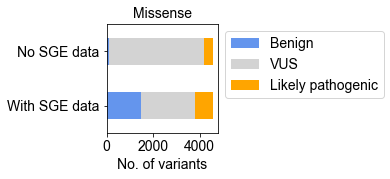

In [18]:
df = pd.read_csv(out_files+'/Missense_denovo_classification_change_w_SGE.txt', '\t')

plt.rcParams["figure.figsize"] = (2,2)
df.plot(
    x = 'SGE',
    kind = 'barh',
    stacked = True,
    title = 'Stacked Bar Graph',
    color=['cornflowerblue','lightgrey', 'orange'], mark_right = True)

plt.title('Missense', fontsize=14)
plt.legend(bbox_to_anchor=(1, 1), fontsize=14)
plt.xlabel('No. of variants', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('')

plt.savefig(out_files+'/Missense_denovo_classification_no_SGE.pdf', dpi=1300, bbox_inches='tight', transparent=True)
plt.show()


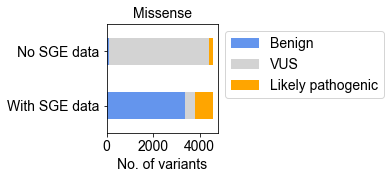

scp er10@gen3-head1://nfs/users/nfs_e/er10/SGE/data/Release_4/Figure_plots/Fig4B_missense_notdenovo_classification_no_SGE.pdf /Users/er10/Documents/Results/SGE_data/Release_4/Figure_plots/Fig4B_missense_notdenovo_classification_no_SGE.pdf


In [19]:
df = pd.read_csv(out_files+'/Missense_notdenovo_classification_change_w_SGE.txt', '\t')

plt.rcParams["figure.figsize"] = (2,2)
df.plot(
    x = 'SGE',
    kind = 'barh',
    stacked = True,
    title = 'Stacked Bar Graph',
    color=['cornflowerblue','lightgrey', 'orange'], mark_right = True)

plt.title('Missense', fontsize=14)
plt.legend(bbox_to_anchor=(1, 1), fontsize=14)
plt.xlabel('No. of variants', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('')

plt.savefig(out_files+'/Fig6C_missense_notdenovo_classification_no_SGE.pdf', dpi=1300, bbox_inches='tight', transparent=True)
plt.show()
print('scp er10@gen3-head1://nfs/users/nfs_e/er10/SGE/data/Release_4/Figure_plots/Fig4B_missense_notdenovo_classification_no_SGE.pdf /Users/er10/Documents/Results/SGE_data/Release_4/Figure_plots/Fig4B_missense_notdenovo_classification_no_SGE.pdf')


In [15]:
''' Synonymous VARIANTS:'''

altered_classification_count_denovos = 0
altered_classification_count_inheritance_unknown = 0

denovo_old_classification={'VUS':0, 'benign':0, 'path':0}
denovo_new_classification={'VUS':0, 'benign':0, 'path':0}
not_denovo_old_classification={'VUS':0, 'benign':0, 'path':0}
not_denovo_new_classification={'VUS':0, 'benign':0, 'path':0}

with open(data_root+'Table_S9_SGE_data_for_all_variants_tested_with_annotation2.txt', 'r')as f:
    header=f.readline().strip().split('\t')
    #print(header)
    ref_codon_col=header.index('ref_codon')
    alt_codon_col=header.index('alt_codon')
    pos_col=header.index('VCF_position')
    ref_col=header.index('VCF_Ref')
    alt_col=header.index('VCF_Alt')
    RF_cat_col=header.index('SGE_prediction_of_variant_function_in_NDD_context')
    cons_col=header.index('Primary_consequence')
    all_cons_col=header.index('Consequence')
    popdb_col=header.index('Population_database')
    Gnomad_maxAF_col=header.index('GnomAD_maxAF')
    prot_pos_col=header.index('Protein_position')
    refaa_col=header.index('ref_aa')
    altaa_col=header.index('alt_aa')
    mut_col=header.index('Variant_design_type')
    cadd_col=header.index('CADD_PHRED')
    revel_col=header.index('revel')
    splAI_col=header.index('SpliceAI_Delta_score')
    lines=f.readlines()
    for line in lines:
        fields=line.strip().split('\t')
        spliceAI =fields[splAI_col].strip()
        pos=int(fields[pos_col].strip())
        ref=fields[ref_col].strip('""')
        alt=fields[alt_col].strip('""')
        RF_cat=fields[RF_cat_col].strip('""')
        VEP=fields[cons_col].strip('""')
        popDB=fields[popdb_col].strip('""')
        Gnomad_maxAF = fields[Gnomad_maxAF_col].strip('""')
        prot_pos=fields[prot_pos_col].strip('""')
        refaa=fields[refaa_col].strip('""')
        altaa=fields[altaa_col].strip('""')
        mutator=fields[mut_col].strip('""')
        cadd=fields[cadd_col].strip('""')
        revel=fields[revel_col].strip('""')
        all_cons=fields[all_cons_col].strip('""').split('/')[0]
        Tatvigian_score = 0
        if mutator != 'snvre':
            if 'synonymous_variant' in all_cons:
                if float(cadd)>=25:
                    Tatvigian_score = Tatvigian_score+1
                elif float(spliceAI) >=0.7:
                    Tatvigian_score = Tatvigian_score+1
                elif float(cadd)<=10:
                    if float(spliceAI) < 0.2:
                        Tatvigian_score = Tatvigian_score-1

                # BS1
                if Gnomad_maxAF not in ['NaN', '']:
                    # BS1, calculated using http://cardiodb.org/allelefrequencyapp/ as follows: Prevalence of DDX3X-related DD: 1/27700, calculated as 1% (population prevalence of ID) x prevalence of DDX3X de novos in the Kaplanis/Samocha analysis (112/31058), which is consistent with previous estimates. Allelic heterogeneity: estimated as 0.09. In the Kaplanis/Samocha analysis, the most common variants was observed 5 times, with a total of 112 different denovo DDX3X variants, 0.09 is the upper bound of the CI. Genetic heterogeneity: 1 Penetrance: 0.5 (likely to be an under-estimate). As the majority of evidence suggests that DDX3X is X-linked dominant I have not worried about the sex of the GnomAD individuals, as an observation of the variant in either males or females would be relevant.
                    if float(Gnomad_maxAF) > 0.00000325:
                            Tatvigian_score = Tatvigian_score-4
                else:
                    # Variant not in GnomAD, moderate evidence it's pathogenic:
                    Tatvigian_score = Tatvigian_score+2

                # Incorporate clinical data:
                # PS1 Add a score of +2 (moderate) if variant is de novo and has been seen before. Score 1 if this variant not denovo, but a denovo variant has been reported as LP/P before
                try:
                    # Are there clinical data available?
                    inh, recurrence = clinical_pathogenic[(str(pos),ref, alt)]
                    if inh == 'denovo':
                        var_score_w_out_SGE_denovo = Tatvigian_score+2
                        var_score_w_SGE_denovo= Tatvigian_score +2
                        var_score_w_out_SGE_not_denovo = Tatvigian_score+1
                        var_score_w_SGE_not_denovo=Tatvigian_score+1
                except KeyError:
                    # PS1 Add a score of +1 (supporting) if the variant is denovo, and not been seen before
                    var_score_w_out_SGE_denovo = Tatvigian_score+1
                    var_score_w_SGE_denovo = Tatvigian_score+1
                    var_score_w_out_SGE_not_denovo = Tatvigian_score
                    var_score_w_SGE_not_denovo = Tatvigian_score

                # Use PS3/BS3 for functional evidence for SGE in order to be conservative
                if RF_cat == '1':
                    var_score_w_SGE_denovo = var_score_w_SGE_denovo+4
                    var_score_w_SGE_not_denovo = var_score_w_SGE_not_denovo+4
                elif RF_cat == '0':
                    var_score_w_SGE_not_denovo = var_score_w_SGE_not_denovo-4
                    var_score_w_SGE_denovo = var_score_w_SGE_denovo-4

                #calculate impact of including SGE data for hypothetical denovo variants
                if var_score_w_out_SGE_denovo >= 6:
                    existing_path_count = denovo_old_classification['path']
                    existing_path_count=existing_path_count+1
                    denovo_old_classification['path']=existing_path_count
                    if var_score_w_SGE_denovo <6:
                        altered_classification_count_denovos=altered_classification_count_denovos+1

                # VUS = 0-5
                elif var_score_w_out_SGE_denovo >=0:
                    existing_VUS_count = denovo_old_classification['VUS']
                    existing_VUS_count=existing_VUS_count+1
                    denovo_old_classification['VUS']=existing_VUS_count
                    if var_score_w_SGE_denovo >=6:
                        altered_classification_count_denovos=altered_classification_count_denovos+1
                    elif var_score_w_SGE_denovo <0:
                        altered_classification_count_denovos=altered_classification_count_denovos+1
                elif var_score_w_out_SGE_denovo <0:
                    existing_benign_count = denovo_old_classification['benign']
                    existing_benign_count=existing_benign_count+1
                    denovo_old_classification['benign']=existing_benign_count
                    if var_score_w_SGE_denovo >=0:
                        altered_classification_count_denovos=altered_classification_count_denovos+1

                #calculate impact of including SGE data for hypothetical variants where the inheritance is unknown
                if var_score_w_out_SGE_not_denovo >= 6:
                    existing_path_count = not_denovo_old_classification['path']
                    existing_path_count=existing_path_count+1
                    not_denovo_old_classification['path']=existing_path_count
                    if var_score_w_SGE_not_denovo <6:
                        altered_classification_count_inheritance_unknown=altered_classification_count_inheritance_unknown+1

                elif var_score_w_out_SGE_not_denovo >=0:
                    existing_VUS_count = not_denovo_old_classification['VUS']
                    existing_VUS_count=existing_VUS_count+1
                    not_denovo_old_classification['VUS']=existing_VUS_count
                    if var_score_w_SGE_not_denovo >=6:
                        altered_classification_count_inheritance_unknown=altered_classification_count_inheritance_unknown+1
                    elif var_score_w_SGE_not_denovo <0:
                        altered_classification_count_inheritance_unknown=altered_classification_count_inheritance_unknown+1

                elif var_score_w_out_SGE_not_denovo <0:
                    existing_benign_count = not_denovo_old_classification['benign']
                    existing_benign_count=existing_benign_count+1
                    not_denovo_old_classification['benign']=existing_benign_count
                    if var_score_w_SGE_not_denovo >=0:
                        altered_classification_count_inheritance_unknown=altered_classification_count_inheritance_unknown+1

                if var_score_w_SGE_denovo >= 6:
                    existing_path_count = denovo_new_classification['path']
                    existing_path_count=existing_path_count+1
                    denovo_new_classification['path']=existing_path_count

                elif var_score_w_SGE_denovo >=0:
                    existing_VUS_count = denovo_new_classification['VUS']
                    existing_VUS_count=existing_VUS_count+1
                    denovo_new_classification['VUS']=existing_VUS_count

                elif var_score_w_SGE_denovo <0:
                    existing_benign_count = denovo_new_classification['benign']
                    existing_benign_count=existing_benign_count+1
                    denovo_new_classification['benign']=existing_benign_count

                if var_score_w_SGE_not_denovo >= 6:
                    existing_path_count = not_denovo_new_classification['path']
                    existing_path_count=existing_path_count+1
                    not_denovo_new_classification['path']=existing_path_count

                elif var_score_w_SGE_not_denovo >=0:
                    existing_VUS_count = not_denovo_new_classification['VUS']
                    existing_VUS_count=existing_VUS_count+1
                    not_denovo_new_classification['VUS']=existing_VUS_count

                elif var_score_w_SGE_not_denovo <0:
                    existing_benign_count = not_denovo_new_classification['benign']
                    existing_benign_count=existing_benign_count+1
                    not_denovo_new_classification['benign']=existing_benign_count

with open(out_files+'/Synonymous_denovo_classification_change_w_SGE.txt', 'w') as out:
    header = '\t'.join(['SGE', 'Benign', 'VUS', 'Likely pathogenic'])+'\n'
    out.write(header)
    line1='\t'.join(['No SGE data', str(denovo_old_classification['benign']), str(denovo_old_classification['VUS']), str(denovo_old_classification['path'])])+'\n'
    line2='\t'.join(['With SGE data', str(denovo_new_classification['benign']), str(denovo_new_classification['VUS']), str(denovo_new_classification['path'])])+'\n'
    out.write(line2)
    out.write(line1)

with open(out_files+'/Synonymous_not_denovo_classification_change_w_SGE.txt', 'w') as out:
    header = '\t'.join(['SGE', 'Benign', 'VUS', 'Likely pathogenic'])+'\n'
    out.write(header)
    line1='\t'.join(['No SGE data', str(not_denovo_old_classification['benign']), str(not_denovo_old_classification['VUS']), str(not_denovo_old_classification['path'])])+'\n'
    line2='\t'.join(['With SGE data', str(not_denovo_new_classification['benign']), str(not_denovo_new_classification['VUS']), str(not_denovo_new_classification['path'])])+'\n'
    out.write(line2)
    out.write(line1)

print('\nSynonymous variants:')
print('denovo vars, no SGE data', denovo_old_classification)
print('denovo vars, with SGE data', denovo_new_classification)
print('inheritance unknown vars, no SGE data', not_denovo_old_classification)
print('inheritance unknown vars, with SGE data', not_denovo_new_classification)
print('number of vars with altered classification, denovos', altered_classification_count_denovos)
print('number of vars with altered classification, inh unknown', altered_classification_count_inheritance_unknown)


Synonymous variants:
denovo vars, no SGE data {'VUS': 1175, 'benign': 126, 'path': 0}
denovo vars, with SGE data {'VUS': 9, 'benign': 1276, 'path': 16}
inheritance unknown vars, no SGE data {'VUS': 1175, 'benign': 126, 'path': 0}
inheritance unknown vars, with SGE data {'VUS': 2, 'benign': 1285, 'path': 14}
number of vars with altered classification, denovos 1166
number of vars with altered classification, inh unknown 1173


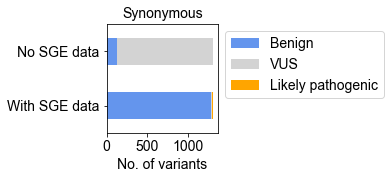

In [23]:
df = pd.read_csv(out_files+'/Synonymous_denovo_classification_change_w_SGE.txt', '\t')

plt.rcParams["figure.figsize"] = (2,2)
df.plot(
    x = 'SGE',
    kind = 'barh',
    stacked = True,
    title = 'Stacked Bar Graph',
    color=['cornflowerblue','lightgrey', 'orange'], mark_right = True)

plt.title('Synonymous', fontsize=14)
plt.legend(bbox_to_anchor=(1, 1), fontsize=14)
plt.xlabel('No. of variants', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('')

plt.savefig(out_files+'/Synonymous_denovo_classification_no_SGE.pdf', dpi=1300, bbox_inches='tight', transparent=True)
plt.show()


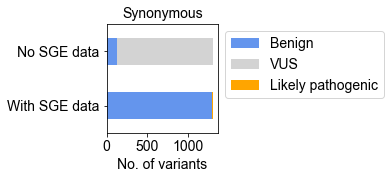

In [16]:
df = pd.read_csv(out_files+'/Synonymous_not_denovo_classification_change_w_SGE.txt', '\t')
   
# plot a Stacked Bar Chart using matplotlib

plt.rcParams["figure.figsize"] = (2,2)
df.plot(
    x = 'SGE',
    kind = 'barh',
    stacked = True,
    title = 'Stacked Bar Graph',
    color=['cornflowerblue','lightgrey', 'orange'], mark_right = True)

plt.title('Synonymous', fontsize=14)
plt.legend(bbox_to_anchor=(1, 1), fontsize=14)
plt.xlabel('No. of variants', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('')
plt.savefig(out_files+'/Fig6C_Synonymous_not_denovo_classification_no_SGE.pdf', dpi=1300, bbox_inches='tight', transparent=True)
plt.show()


In [17]:
''' NONCODING VARIANTS 
Following recommendations in Ellingford et al. Medrxiv 2021
'''

altered_classification_count_denovos = 0
altered_classification_count_inheritance_unknown = 0

denovo_old_classification={'VUS':0, 'benign':0, 'path':0}
denovo_new_classification={'VUS':0, 'benign':0, 'path':0}
not_denovo_old_classification={'VUS':0, 'benign':0, 'path':0}
not_denovo_new_classification={'VUS':0, 'benign':0, 'path':0}

with open(data_root+'Table_S9_SGE_data_for_all_variants_tested_with_annotation2.txt', 'r')as f:
    header=f.readline().strip().split('\t')
    #print(header)
    ref_codon_col=header.index('ref_codon')
    alt_codon_col=header.index('alt_codon')
    pos_col=header.index('VCF_position')
    ref_col=header.index('VCF_Ref')
    alt_col=header.index('VCF_Alt')
    RF_cat_col=header.index('SGE_prediction_of_variant_function_in_NDD_context')
    cons_col=header.index('Primary_consequence')
    all_cons_col=header.index('Consequence')
    popdb_col=header.index('Population_database')
    Gnomad_maxAF_col=header.index('GnomAD_maxAF')
    prot_pos_col=header.index('Protein_position')
    refaa_col=header.index('ref_aa')
    altaa_col=header.index('alt_aa')
    mut_col=header.index('Variant_design_type')
    cadd_col=header.index('CADD_PHRED')
    revel_col=header.index('revel')
    splAI_col=header.index('SpliceAI_Delta_score')
    lines=f.readlines()
    for line in lines:
        fields=line.strip().split('\t')
        spliceAI =fields[splAI_col].strip()
        pos=int(fields[pos_col].strip())
        ref=fields[ref_col].strip('""')
        alt=fields[alt_col].strip('""')
        RF_cat=fields[RF_cat_col].strip('""')
        VEP=fields[cons_col].strip('""')
        popDB=fields[popdb_col].strip('""')
        Gnomad_maxAF = fields[Gnomad_maxAF_col].strip('""')
        prot_pos=fields[prot_pos_col].strip('""')
        refaa=fields[refaa_col].strip('""')
        altaa=fields[altaa_col].strip('""')
        mutator=fields[mut_col].strip('""')
        cadd=fields[cadd_col].strip('""')
        revel=fields[revel_col].strip('""')
        all_cons=fields[all_cons_col].strip('""').split('/')[0]
        Tatvigian_score = 0
        if mutator != 'snvre':
            if VEP in ['5_UTR_variant', '3_UTR_variant', 'intron_variant', 'splice_region_variant']:
                if 'synonymous_variant' not in all_cons:
                    # in silico evidence of pathogenicity, PP3/BP4. ClinGen SVI recommend Revel >0.7 PP3, Decipher use <0.4 BP4. Otherwise use cadd > 25 and < 10.
                    if cadd:
                        if float(cadd)>=25:
                            Tatvigian_score = Tatvigian_score+1
                        elif float(spliceAI) >=0.7:
                            Tatvigian_score = Tatvigian_score+1
                        elif float(cadd)<=10:
                            if float(spliceAI) < 0.2:
                                Tatvigian_score = Tatvigian_score-1
                
                    # BS1
                    if Gnomad_maxAF not in ['NaN', '']:
                        # BS1, calculated using http://cardiodb.org/allelefrequencyapp/ as follows: Prevalence of DDX3X-related DD: 1/27700, calculated as 1% (population prevalence of ID) x prevalence of DDX3X de novos in the Kaplanis/Samocha analysis (112/31058), which is consistent with previous estimates. Allelic heterogeneity: estimated as 0.09. In the Kaplanis/Samocha analysis, the most common variants was observed 5 times, with a total of 112 different denovo DDX3X variants, 0.09 is the upper bound of the CI. Genetic heterogeneity: 1 Penetrance: 0.5 (likely to be an under-estimate). As the majority of evidence suggests that DDX3X is X-linked dominant I have not worried about the sex of the GnomAD individuals, as an observation of the variant in either males or females would be relevant.
                        if float(Gnomad_maxAF) > 0.00000325:
                                Tatvigian_score = Tatvigian_score-4
                    else:
                        # Variant not in GnomAD, moderate evidence it's pathogenic:
                        Tatvigian_score = Tatvigian_score+2

                    # Incorporate clinical data:
                    # PS2 Add a score of +2 (moderate) if variant is de novo and has been seen before. Score at supporting if this variant not denovo, but a denovo variant has been reported as LP/P before
                    try:
                        # Are there clinical data available?
                        inh, recurrence = clinical_pathogenic[(str(pos),ref, alt)]
                        if inh == 'denovo':
                            var_score_w_out_SGE_denovo = Tatvigian_score+2
                            var_score_w_SGE_denovo= Tatvigian_score +2
                            var_score_w_out_SGE_not_denovo = Tatvigian_score+1
                            var_score_w_SGE_not_denovo=Tatvigian_score+1
                    except KeyError:
                        # PS1 Add a score of +1 (supporting) if the variant is denovo, and not been seen before
                        var_score_w_out_SGE_denovo = Tatvigian_score+1
                        var_score_w_SGE_denovo = Tatvigian_score+1
                        var_score_w_out_SGE_not_denovo = Tatvigian_score
                        var_score_w_SGE_not_denovo = Tatvigian_score

                    # Use PS3/BS3 for functional evidence for SGE in order to be conservative
                    if RF_cat == '1':
                        var_score_w_SGE_denovo = var_score_w_SGE_denovo+4
                        var_score_w_SGE_not_denovo = var_score_w_SGE_not_denovo+4
                    elif RF_cat == '0':
                        var_score_w_SGE_not_denovo = var_score_w_SGE_not_denovo-4
                        var_score_w_SGE_denovo = var_score_w_SGE_denovo-4

                    #calculate impact of including SGE data for hypothetical denovo variants
                    if var_score_w_out_SGE_denovo >= 6:
                        existing_path_count = denovo_old_classification['path']
                        existing_path_count=existing_path_count+1
                        denovo_old_classification['path']=existing_path_count
                        if var_score_w_SGE_denovo <6:
                            altered_classification_count_denovos=altered_classification_count_denovos+1

                    # VUS = 0-5
                    elif var_score_w_out_SGE_denovo >=0:
                        existing_VUS_count = denovo_old_classification['VUS']
                        existing_VUS_count=existing_VUS_count+1
                        denovo_old_classification['VUS']=existing_VUS_count
                        if var_score_w_SGE_denovo >=6:
                            altered_classification_count_denovos=altered_classification_count_denovos+1
                        elif var_score_w_SGE_denovo <0:
                            altered_classification_count_denovos=altered_classification_count_denovos+1
                    elif var_score_w_out_SGE_denovo <0:
                        existing_benign_count = denovo_old_classification['benign']
                        existing_benign_count=existing_benign_count+1
                        denovo_old_classification['benign']=existing_benign_count
                        if var_score_w_SGE_denovo >=0:
                            altered_classification_count_denovos=altered_classification_count_denovos+1

                    #calculate impact of including SGE data for hypothetical variants where the inheritance is unknown
                    if var_score_w_out_SGE_not_denovo >= 6:
                        existing_path_count = not_denovo_old_classification['path']
                        existing_path_count=existing_path_count+1
                        not_denovo_old_classification['path']=existing_path_count
                        if var_score_w_SGE_not_denovo <6:
                            altered_classification_count_inheritance_unknown=altered_classification_count_inheritance_unknown+1

                    elif var_score_w_out_SGE_not_denovo >=0:
                        existing_VUS_count = not_denovo_old_classification['VUS']
                        existing_VUS_count=existing_VUS_count+1
                        not_denovo_old_classification['VUS']=existing_VUS_count
                        if var_score_w_SGE_not_denovo >=6:
                            altered_classification_count_inheritance_unknown=altered_classification_count_inheritance_unknown+1
                        elif var_score_w_SGE_not_denovo <0:
                            altered_classification_count_inheritance_unknown=altered_classification_count_inheritance_unknown+1

                    elif var_score_w_out_SGE_not_denovo <0:
                        existing_benign_count = not_denovo_old_classification['benign']
                        existing_benign_count=existing_benign_count+1
                        not_denovo_old_classification['benign']=existing_benign_count
                        if var_score_w_SGE_not_denovo >=0:
                            altered_classification_count_inheritance_unknown=altered_classification_count_inheritance_unknown+1

                    if var_score_w_SGE_denovo >= 6:
                        existing_path_count = denovo_new_classification['path']
                        existing_path_count=existing_path_count+1
                        denovo_new_classification['path']=existing_path_count

                    elif var_score_w_SGE_denovo >=0:
                        existing_VUS_count = denovo_new_classification['VUS']
                        existing_VUS_count=existing_VUS_count+1
                        denovo_new_classification['VUS']=existing_VUS_count

                    elif var_score_w_SGE_denovo <0:
                        existing_benign_count = denovo_new_classification['benign']
                        existing_benign_count=existing_benign_count+1
                        denovo_new_classification['benign']=existing_benign_count

                    if var_score_w_SGE_not_denovo >= 6:
                        existing_path_count = not_denovo_new_classification['path']
                        existing_path_count=existing_path_count+1
                        not_denovo_new_classification['path']=existing_path_count

                    elif var_score_w_SGE_not_denovo >=0:
                        existing_VUS_count = not_denovo_new_classification['VUS']
                        existing_VUS_count=existing_VUS_count+1
                        not_denovo_new_classification['VUS']=existing_VUS_count

                    elif var_score_w_SGE_not_denovo <0:
                        existing_benign_count = not_denovo_new_classification['benign']
                        existing_benign_count=existing_benign_count+1
                        not_denovo_new_classification['benign']=existing_benign_count

with open(out_files+'/Noncoding_denovo_classification_change_w_SGE.txt', 'w') as out:
    header = '\t'.join(['SGE', 'Benign', 'VUS', 'Likely pathogenic'])+'\n'
    out.write(header)
    line1='\t'.join(['No SGE data', str(denovo_old_classification['benign']), str(denovo_old_classification['VUS']), str(denovo_old_classification['path'])])+'\n'
    line2='\t'.join(['With SGE data', str(denovo_new_classification['benign']), str(denovo_new_classification['VUS']), str(denovo_new_classification['path'])])+'\n'
    out.write(line2)
    out.write(line1)

with open(out_files+'/Noncoding_not_denovo_classification_change_w_SGE.txt', 'w') as out:
    header = '\t'.join(['SGE', 'Benign', 'VUS', 'Likely pathogenic'])+'\n'
    out.write(header)
    line1='\t'.join(['No SGE data', str(not_denovo_old_classification['benign']), str(not_denovo_old_classification['VUS']), str(not_denovo_old_classification['path'])])+'\n'
    line2='\t'.join(['With SGE data', str(not_denovo_new_classification['benign']), str(not_denovo_new_classification['VUS']), str(not_denovo_new_classification['path'])])+'\n'
    out.write(line2)
    out.write(line1)

print('\nNoncoding variants')
print('denovo vars, no SGE data', denovo_old_classification)
print('denovo vars, with SGE data', denovo_new_classification)
print('inheritance unknown vars, no SGE data', not_denovo_old_classification)
print('inheritance unknown vars, with SGE data', not_denovo_new_classification)
print('number of vars with altered classification, denovos', altered_classification_count_denovos)
print('number of vars with altered classification, inh unknown', altered_classification_count_inheritance_unknown)


Noncoding variants
denovo vars, no SGE data {'VUS': 1732, 'benign': 154, 'path': 0}
denovo vars, with SGE data {'VUS': 36, 'benign': 1769, 'path': 81}
inheritance unknown vars, no SGE data {'VUS': 1727, 'benign': 159, 'path': 0}
inheritance unknown vars, with SGE data {'VUS': 8, 'benign': 1805, 'path': 73}
number of vars with altered classification, denovos 1696
number of vars with altered classification, inh unknown 1719


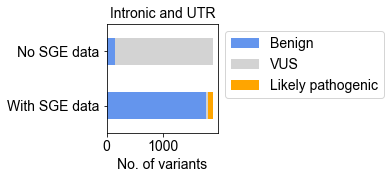

In [26]:
df = pd.read_csv(out_files+'/Noncoding_denovo_classification_change_w_SGE.txt', '\t')
    
# plot a Stacked Bar Chart using matplotlib

plt.rcParams["figure.figsize"] = (2,2)
df.plot(
    x = 'SGE',
    kind = 'barh',
    stacked = True,
    title = 'Stacked Bar Graph',
    color=['cornflowerblue','lightgrey', 'orange'], mark_right = True)

plt.title('Intronic and UTR', fontsize=14)
plt.legend(bbox_to_anchor=(1, 1), fontsize=14)
plt.xlabel('No. of variants', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('')
plt.savefig(out_files+'/Noncoding_denovo_classification_no_SGE.pdf', dpi=1300, bbox_inches='tight', transparent=True)
plt.show()

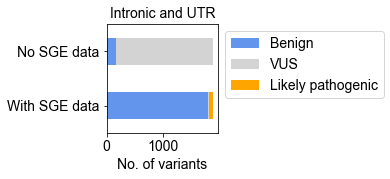

scp er10@gen3-head1://nfs/users/nfs_e/er10/SGE/data/Release_4/Figure_plots//Fig4B_Noncoding_not_denovo_classification_no_SGE.pdf /Users/er10/Documents/Results/SGE_data/Release_4/Figure_plots/Fig4B_Noncoding_not_denovo_classification_impact_SGE.pdf


In [27]:
df = pd.read_csv(out_files+'/Noncoding_not_denovo_classification_change_w_SGE.txt', '\t')
    
# plot a Stacked Bar Chart using matplotlib

plt.rcParams["figure.figsize"] = (2,2)
df.plot(
    x = 'SGE',
    kind = 'barh',
    stacked = True,
    title = 'Stacked Bar Graph',
    color=['cornflowerblue','lightgrey', 'orange'], mark_right = True)

plt.title('Intronic and UTR', fontsize=14)
plt.legend(bbox_to_anchor=(1, 1), fontsize=14)
plt.xlabel('No. of variants', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('')
plt.savefig(out_files+'/Fig6C_Noncoding_not_denovo_classification_no_SGE.pdf', dpi=1300, bbox_inches='tight', transparent=True)
plt.show()



In [18]:
''' 
FRAMESHIFT AND NON-SENSE VARIANTS
- predicted to undergo NMD + in biologically revelant transcript = PVS1 - very strong
- LOFs are not frequent in the general population (no LOFs in GnomAD, even in the end of the portion of the protein which escapes NMD). Therefore this region scored as follows:
- Not predicted to undergo NMD + in biologically relevant transcript, portion of protein of unknown function (outside the helicase domains), <10% protein truncated - moderate
- Not predicted to undergo NMD + in biologically relevant transcript, portion of protein of unknown function (outside the helicase domains), > 10% of protein: strong

Start-lost variants:
- PVS1 scored as moderate (as there is more than 1 reported pathogenic variant upstream of next possible start codon (which is in exon 7))
'''
altered_classification_count_denovos = 0
altered_classification_count_inheritance_unknown = 0

denovo_old_classification={'VUS':0, 'benign':0, 'path':0}
denovo_new_classification={'VUS':0, 'benign':0, 'path':0}
not_denovo_old_classification={'VUS':0, 'benign':0, 'path':0}
not_denovo_new_classification={'VUS':0, 'benign':0, 'path':0}

with open(data_root+'Table_S9_SGE_data_for_all_variants_tested_with_annotation2.txt', 'r')as f:
    header=f.readline().strip().split('\t')
    #print(header)
    ref_codon_col=header.index('ref_codon')
    alt_codon_col=header.index('alt_codon')
    pos_col=header.index('VCF_position')
    ref_col=header.index('VCF_Ref')
    alt_col=header.index('VCF_Alt')
    RF_cat_col=header.index('SGE_prediction_of_variant_function_in_NDD_context')
    cons_col=header.index('Primary_consequence')
    all_cons_col=header.index('Consequence')
    popdb_col=header.index('Population_database')
    Gnomad_maxAF_col=header.index('GnomAD_maxAF')
    prot_pos_col=header.index('Protein_position')
    refaa_col=header.index('ref_aa')
    altaa_col=header.index('alt_aa')
    mut_col=header.index('Variant_design_type')
    cadd_col=header.index('CADD_PHRED')
    revel_col=header.index('revel')
    splAI_col=header.index('SpliceAI_Delta_score')
    lines=f.readlines()
    for line in lines:
        fields=line.strip().split('\t')
        spliceAI =fields[splAI_col].strip()
        pos=int(fields[pos_col].strip())
        ref=fields[ref_col].strip('""')
        alt=fields[alt_col].strip('""')
        RF_cat=fields[RF_cat_col].strip('""')
        VEP=fields[cons_col].strip('""')
        popDB=fields[popdb_col].strip('""')
        Gnomad_maxAF = fields[Gnomad_maxAF_col].strip('""')
        prot_pos=fields[prot_pos_col].strip('""')
        refaa=fields[refaa_col].strip('""')
        altaa=fields[altaa_col].strip('""')
        mutator=fields[mut_col].strip('""')
        cadd=fields[cadd_col].strip('""')
        revel=fields[revel_col].strip('""')
        all_cons=fields[all_cons_col].strip('""').split('/')[0]
        Tatvigian_score = 0
        if mutator != 'snvre':
            if 'start_lost' in VEP:
                Tatvigian_score = Tatvigian_score+2
            elif VEP in ['frameshift_variant', 'stop_gained']:
                if pos > 41334428:
                    if pos < 41347396:
                        # variant predicted to undergo NMD
                        Tatvigian_score = Tatvigian_score+8
                    else:
                        # function of C-terminal unknown, and portion of protein of unknown function, LOFs not frequent in general population, <10% protein - moderate
                        Tatvigian_score = Tatvigian_score+2
                else:
                    # in first 200bp of coding sequence > 10% protein - moderate
                    Tatvigian_score = Tatvigian_score+4

                # in silico evidence of pathogenicity, PP3/BP4. ClinGen SVI recommend Revel >0.7 PP3, Decipher use <0.4 BP4. Otherwise use cadd > 25 and < 10.
                if 'No_revel_score' in revel:
                    # if no revel score, score and cadd >=25 or spliceAI > 0.7 - PP3. If spliceAI < 0.7 and cadd<25 or revel<0.7 = BP4
                    if cadd:
                        if float(cadd)>=25:
                            Tatvigian_score = Tatvigian_score+1
                        elif spliceAI != '-':
                            if float(spliceAI) >=0.7:
                                Tatvigian_score = Tatvigian_score+1
                        if float(cadd)<=10:
                            if float(spliceAI) < 0.2:
                                Tatvigian_score = Tatvigian_score-1

                elif float(revel)>=0.7:
                    Tatvigian_score = Tatvigian_score+1
                elif float(spliceAI) >=0.7:
                        Tatvigian_score = Tatvigian_score+1
                elif float(spliceAI)<0.2:
                    if float(revel)<=0.2:
                        Tatvigian_score = Tatvigian_score-1
                # BS1
                if Gnomad_maxAF not in ['NaN', '']:
                    # BS1, calculated using http://cardiodb.org/allelefrequencyapp/ as follows: Prevalence of DDX3X-related DD: 1/27700, calculated as 1% (population prevalence of ID) x prevalence of DDX3X de novos in the Kaplanis/Samocha analysis (112/31058), which is consistent with previous estimates. Allelic heterogeneity: estimated as 0.09. In the Kaplanis/Samocha analysis, the most common variants was observed 5 times, with a total of 112 different denovo DDX3X variants, 0.09 is the upper bound of the CI. Genetic heterogeneity: 1 Penetrance: 0.5 (likely to be an under-estimate). As the majority of evidence suggests that DDX3X is X-linked dominant I have not worried about the sex of the GnomAD individuals, as an observation of the variant in either males or females would be relevant.
                    if float(Gnomad_maxAF) > 0.00000325:
                            Tatvigian_score = Tatvigian_score-4
                else:
                    # Variant not in GnomAD, moderate evidence it's pathogenic:
                    Tatvigian_score = Tatvigian_score+2
                
                # PS1 Add a score of +1 (supporting) if the variant is denovo, and not been seen before. Add a score of +2 (moderate) if variant is de novo and has been seen before. 
                # Score 1 if this variant not denovo, but a denovo variant has been reported as LP/P before
                try:
                    # Are there clinical data available?
                    inh, recurrence = clinical_pathogenic[(str(pos),ref, alt)]
                    if inh == 'denovo':
                        var_score_w_out_SGE_denovo = Tatvigian_score+2
                        var_score_w_SGE_denovo= Tatvigian_score +2
                        var_score_w_out_SGE_not_denovo = Tatvigian_score+1
                        var_score_w_SGE_not_denovo=Tatvigian_score+1
                    else:
                        var_score_w_out_SGE_denovo = Tatvigian_score+1
                        var_score_w_SGE_denovo = Tatvigian_score+1
                        var_score_w_out_SGE_not_denovo = Tatvigian_score
                        var_score_w_SGE_not_denovo = Tatvigian_score
                except KeyError:
                    if (pos, ref, alt) == (41347415, 'G', 'T'):
                        print('no clinical data available score', Tatvigian_score)
                    var_score_w_out_SGE_denovo = Tatvigian_score+1
                    var_score_w_SGE_denovo = Tatvigian_score+1
                    var_score_w_out_SGE_not_denovo = Tatvigian_score
                    var_score_w_SGE_not_denovo = Tatvigian_score
                
                # Use PS3/BS3 for functional evidence for SGE in order to be conservative
                if RF_cat == '1':
                    var_score_w_SGE_denovo = var_score_w_SGE_denovo+4
                    var_score_w_SGE_not_denovo = var_score_w_SGE_not_denovo+4
                elif RF_cat == '0':
                    var_score_w_SGE_not_denovo = var_score_w_SGE_not_denovo-4
                    var_score_w_SGE_denovo = var_score_w_SGE_denovo-4
                
                #calculate impact of including SGE data for hypothetical denovo variants
                if var_score_w_out_SGE_denovo >= 6:
                    existing_path_count = denovo_old_classification['path']
                    existing_path_count=existing_path_count+1
                    denovo_old_classification['path']=existing_path_count
                    if var_score_w_SGE_denovo <6:
                        altered_classification_count_denovos=altered_classification_count_denovos+1

                elif var_score_w_out_SGE_denovo >=0:
                    existing_VUS_count = denovo_old_classification['VUS']
                    existing_VUS_count=existing_VUS_count+1
                    denovo_old_classification['VUS']=existing_VUS_count
                    if var_score_w_SGE_denovo >=6:
                        altered_classification_count_denovos=altered_classification_count_denovos+1
                    elif var_score_w_SGE_denovo <0:
                        altered_classification_count_denovos=altered_classification_count_denovos+1
                elif var_score_w_out_SGE_denovo <0:
                    existing_benign_count = denovo_old_classification['benign']
                    existing_benign_count=existing_benign_count+1
                    denovo_old_classification['benign']=existing_benign_count
                    if var_score_w_SGE_denovo >=0:
                        altered_classification_count_denovos=altered_classification_count_denovos+1

                #calculate impact of including SGE data for hypothetical variants where the inheritance is unknown
                if var_score_w_out_SGE_not_denovo >= 6:
                    existing_path_count = not_denovo_old_classification['path']
                    existing_path_count=existing_path_count+1
                    not_denovo_old_classification['path']=existing_path_count
                    if var_score_w_SGE_not_denovo <6:
                        altered_classification_count_inheritance_unknown=altered_classification_count_inheritance_unknown+1

                elif var_score_w_out_SGE_not_denovo >=0:
                    existing_VUS_count = not_denovo_old_classification['VUS']
                    existing_VUS_count=existing_VUS_count+1
                    not_denovo_old_classification['VUS']=existing_VUS_count
                    if var_score_w_SGE_not_denovo >=6:
                        altered_classification_count_inheritance_unknown=altered_classification_count_inheritance_unknown+1
                    elif var_score_w_SGE_not_denovo <0:
                        altered_classification_count_inheritance_unknown=altered_classification_count_inheritance_unknown+1

                elif var_score_w_out_SGE_not_denovo <0:
                    existing_benign_count = not_denovo_old_classification['benign']
                    existing_benign_count=existing_benign_count+1
                    not_denovo_old_classification['benign']=existing_benign_count
                    if var_score_w_SGE_not_denovo >=0:
                        altered_classification_count_inheritance_unknown=altered_classification_count_inheritance_unknown+1

                if var_score_w_SGE_denovo >= 6:
                    existing_path_count = denovo_new_classification['path']
                    existing_path_count=existing_path_count+1
                    denovo_new_classification['path']=existing_path_count

                elif var_score_w_SGE_denovo >=0:
                    existing_VUS_count = denovo_new_classification['VUS']
                    existing_VUS_count=existing_VUS_count+1
                    denovo_new_classification['VUS']=existing_VUS_count

                elif var_score_w_SGE_denovo <0:
                    existing_benign_count = denovo_new_classification['benign']
                    existing_benign_count=existing_benign_count+1
                    denovo_new_classification['benign']=existing_benign_count

                if var_score_w_SGE_not_denovo >= 6:
                    existing_path_count = not_denovo_new_classification['path']
                    existing_path_count=existing_path_count+1
                    not_denovo_new_classification['path']=existing_path_count

                elif var_score_w_SGE_not_denovo >=0:
                    existing_VUS_count = not_denovo_new_classification['VUS']
                    existing_VUS_count=existing_VUS_count+1
                    not_denovo_new_classification['VUS']=existing_VUS_count

                elif var_score_w_SGE_not_denovo <0:
                    existing_benign_count = not_denovo_new_classification['benign']
                    existing_benign_count=existing_benign_count+1
                    not_denovo_new_classification['benign']=existing_benign_count

with open(out_files+'/LOF_denovo_classification_change_w_SGE.txt', 'w') as out:
    header = '\t'.join(['SGE', 'Benign', 'VUS', 'Likely pathogenic'])+'\n'
    out.write(header)
    line1='\t'.join(['No SGE data', str(denovo_old_classification['benign']), str(denovo_old_classification['VUS']), str(denovo_old_classification['path'])])+'\n'
    line2='\t'.join(['With SGE data', str(denovo_new_classification['benign']), str(denovo_new_classification['VUS']), str(denovo_new_classification['path'])])+'\n'
    out.write(line2)
    out.write(line1)

with open(out_files+'/LOF_not_denovo_classification_change_w_SGE.txt', 'w') as out:
    header = '\t'.join(['SGE', 'Benign', 'VUS', 'Likely pathogenic'])+'\n'
    out.write(header)
    line1='\t'.join(['No SGE data', str(not_denovo_old_classification['benign']), str(not_denovo_old_classification['VUS']), str(not_denovo_old_classification['path'])])+'\n'
    line2='\t'.join(['With SGE data', str(not_denovo_new_classification['benign']), str(not_denovo_new_classification['VUS']), str(not_denovo_new_classification['path'])])+'\n'
    out.write(line2)
    out.write(line1)       

print('\nFrameshift and nonsense variants')
print('denovo vars, no SGE data', denovo_old_classification)
print('denovo vars, with SGE data', denovo_new_classification)
print('inheritance unknown vars, no SGE data', not_denovo_old_classification)
print('inheritance unknown vars, with SGE data', not_denovo_new_classification)
print('number of vars with altered classification, denovos', altered_classification_count_denovos)
print('number of vars with altered classification, inh unknown', altered_classification_count_inheritance_unknown)


no clinical data available score 5

Frameshift and nonsense variants
denovo vars, no SGE data {'VUS': 0, 'benign': 0, 'path': 321}
denovo vars, with SGE data {'VUS': 17, 'benign': 0, 'path': 304}
inheritance unknown vars, no SGE data {'VUS': 21, 'benign': 0, 'path': 300}
inheritance unknown vars, with SGE data {'VUS': 17, 'benign': 0, 'path': 304}
number of vars with altered classification, denovos 17
number of vars with altered classification, inh unknown 4


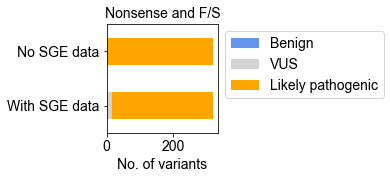

In [19]:
df = pd.read_csv(out_files+'/LOF_denovo_classification_change_w_SGE.txt', '\t')
    
# plot a Stacked Bar Chart using matplotlib

plt.rcParams["figure.figsize"] = (2,2)
df.plot(
    x = 'SGE',
    kind = 'barh',
    stacked = True,
    title = 'Stacked Bar Graph',
    color=['cornflowerblue','lightgrey', 'orange'], mark_right = True)

plt.title('Nonsense and F/S', fontsize=14)
plt.legend(bbox_to_anchor=(1, 1), fontsize=14)
plt.xlabel('No. of variants', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('')

plt.savefig(out_files+'/LOF_denovo_classification_no_SGE.pdf', dpi=1300, bbox_inches='tight', transparent=True)
plt.show()

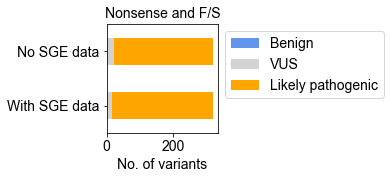

scp er10@gen3-head1://nfs/users/nfs_e/er10/SGE/data/Release_4/Figure_plots/Fig4B_LOF_not_denovo_classification_no_SGE.pdf /Users/er10/Documents/Results/SGE_data/Release_4/Figure_plots/Fig4B_LOF_not_denovo_classification_impact_SGE.pdf


In [31]:
df = pd.read_csv(out_files+'/LOF_not_denovo_classification_change_w_SGE.txt', '\t')
    
# plot a Stacked Bar Chart using matplotlib

plt.rcParams["figure.figsize"] = (2,2)
df.plot(
    x = 'SGE',
    kind = 'barh',
    stacked = True,
    title = 'Stacked Bar Graph',
    color=['cornflowerblue','lightgrey', 'orange'], mark_right = True)

plt.title('Nonsense and F/S', fontsize=14)
plt.legend(bbox_to_anchor=(1, 1), fontsize=14)
plt.xlabel('No. of variants', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('')
plt.savefig(out_files+'/Fig6C_LOF_not_denovo_classification_no_SGE.pdf', dpi=1300, bbox_inches='tight', transparent=True)
plt.show()


In [20]:
''' 
Splice variants
NB all DDX3X exons are < 10% of the length of the protein.
- PP3 should not be used to avoid 'double counting'
- exon skipping --> disrupts reading frame + predicted to undergo NMD  --> PVS1 - very strong
- exon skipping --> disrupts reading frame + not predicted to undergo NMD, outside of the helicase domains, as DDX3X LOFs are not observed in GnomAD, truncates protein by >10% protein length - PVS1 scored as strong
- exon skipping --> disrupts reading frame + not predicted to undergo NMD, outside of the helicase domains, as DDX3X LOFs are not observed in GnomAD, truncates protein by <10% protein length - PVS1 scored as moderate

- exon skipping preserves reading frame + skipped exon lies within the helicase domains - PVS1 scored as strong
- exon skipping preserves reading frame + outside of the helicase domains. Removes < 10% protein (all DDX3X exons are < 10% of the length of the protein) - PVS1 scored as moderate

PM4 - moderate: in-frame or stop-loss changes

'''
# Treat exon 1 as out of frame, although it is inframe, but skipping exon 1 will remove the ATG and there isn't another one until exon 7.
exon_frame={1:'out of frame', 2:'out of frame',3:'inframe',4:'out of frame',5:'inframe',6:'out of frame',7:'out of frame',8:'out of frame',9:'inframe',10:'out of frame',
            11:'out of frame',12:'out of frame',13:'out of frame',14:'out of frame',15:'out of frame',16:'out of frame', 17:'out of frame'}

Uniprot_domains=[['Helicase_ATP_binding',41343302, 41345442], ['Helicase_C', 41345472,41346968]]
#Uniprot domains cover exons 7-15 (inclusive)
Helicase_exons=[7,8,9,10,11,12,13,14,15]

altered_classification_count_denovos = 0
altered_classification_count_inheritance_unknown = 0

denovo_old_classification={'VUS':0, 'benign':0, 'path':0}
denovo_new_classification={'VUS':0, 'benign':0, 'path':0}
not_denovo_old_classification={'VUS':0, 'benign':0, 'path':0}
not_denovo_new_classification={'VUS':0, 'benign':0, 'path':0}

with open(data_root+'Table_S9_SGE_data_for_all_variants_tested_with_annotation2.txt', 'r')as f:
    header=f.readline().strip().split('\t')
    #print(header)
    ref_codon_col=header.index('ref_codon')
    alt_codon_col=header.index('alt_codon')
    pos_col=header.index('VCF_position')
    ref_col=header.index('VCF_Ref')
    alt_col=header.index('VCF_Alt')
    RF_cat_col=header.index('SGE_prediction_of_variant_function_in_NDD_context')
    cons_col=header.index('Primary_consequence')
    all_cons_col=header.index('Consequence')
    popdb_col=header.index('Population_database')
    Gnomad_maxAF_col=header.index('GnomAD_maxAF')
    prot_pos_col=header.index('Protein_position')
    refaa_col=header.index('ref_aa')
    altaa_col=header.index('alt_aa')
    mut_col=header.index('Variant_design_type')
    cadd_col=header.index('CADD_PHRED')
    revel_col=header.index('revel')
    splAI_col=header.index('SpliceAI_Delta_score')
    intron_col=header.index('INTRON')
    exon_col=header.index('EXON')
    lines=f.readlines()
    for line in lines:
        fields=line.strip().split('\t')
        spliceAI =fields[splAI_col].strip()
        pos=int(fields[pos_col].strip())
        ref=fields[ref_col].strip('""')
        alt=fields[alt_col].strip('""')
        RF_cat=fields[RF_cat_col].strip('""')
        VEP=fields[cons_col].strip('""')
        popDB=fields[popdb_col].strip('""')
        Gnomad_maxAF = fields[Gnomad_maxAF_col].strip('""')
        prot_pos=fields[prot_pos_col].strip('""')
        refaa=fields[refaa_col].strip('""')
        altaa=fields[altaa_col].strip('""')
        mutator=fields[mut_col].strip('""')
        cadd=fields[cadd_col].strip('""')
        revel=fields[revel_col].strip('""')
        all_cons=fields[all_cons_col].strip('""').split('/')[0]
        Tatvigian_score = 0
        intron=fields[intron_col].strip('""').split('/')[0]
        #exon=fields[exon_col].strip('""').split('/')[0]
        if mutator != 'snvre':
            if VEP in ['splice_donor_variant', 'splice_acceptor_variant']:
                intron = int(intron)
                if 'splice_donor_variant' in VEP:
                    exon = intron
                    frame = exon_frame[exon]
                elif 'splice_acceptor_variant' in VEP:
                    exon = intron+1
                    frame = exon_frame[exon]
                if frame == 'inframe':
                    if exon in Helicase_exons:
                        # Predicted to cause in-frame exon skipping. If within the Uniprot helicase domains: strong, if not, then moderate because all exons are less than 66aa long (10% of protein)
                        Tatvigian_score = Tatvigian_score+4
                    else:
                        Tatvigian_score = Tatvigian_score+2
                else:
                    # out of frame exons
                    if pos > 41334428:
                        if pos < 41347396:
                            # In region predicted to undergo NMD
                            # Skipping of an out of frame exon would be predicted to cause a frameshift within the region of DDX3X expected to undergo NMD
                            Tatvigian_score = Tatvigian_score+8
                        else:
                            # function of C-terminal unknown, outside of the helicase domain, as LOFs not frequent in general population and truncates <10% protein - moderate
                            Tatvigian_score = Tatvigian_score+2
                    else:
                        # in first 200bp, portion of protein of unknown function, LOFs not frequent in general population, will truncate >10% protein - moderate
                        Tatvigian_score = Tatvigian_score+4

                # BS1
                if Gnomad_maxAF not in ['NaN', '']:
                    # BS1, calculated using http://cardiodb.org/allelefrequencyapp/ as follows: Prevalence of DDX3X-related DD: 1/27700, calculated as 1% (population prevalence of ID) x prevalence of DDX3X de novos in the Kaplanis/Samocha analysis (112/31058), which is consistent with previous estimates. Allelic heterogeneity: estimated as 0.09. In the Kaplanis/Samocha analysis, the most common variants was observed 5 times, with a total of 112 different denovo DDX3X variants, 0.09 is the upper bound of the CI. Genetic heterogeneity: 1 Penetrance: 0.5 (likely to be an under-estimate). As the majority of evidence suggests that DDX3X is X-linked dominant I have not worried about the sex of the GnomAD individuals, as an observation of the variant in either males or females would be relevant.
                    if float(Gnomad_maxAF) > 0.00000325:
                            Tatvigian_score = Tatvigian_score-4
                else:
                    # Variant not in GnomAD, moderate evidence it's pathogenic:
                    Tatvigian_score = Tatvigian_score+2

                # Add a score of +1 (supporting) if the variant is denovo, 0 if not denovo
                var_score_w_out_SGE_denovo = Tatvigian_score+1
                var_score_w_out_SGE_not_denovo = Tatvigian_score
                
                # Use PS3/BS3 for functional evidence for SGE in order to be conservative
                if RF_cat == '1':
                    var_score_w_SGE_denovo = Tatvigian_score+1+4
                    var_score_w_SGE_not_denovo = Tatvigian_score+4
                elif RF_cat == '0':
                    var_score_w_SGE_not_denovo = Tatvigian_score-4
                    var_score_w_SGE_denovo = Tatvigian_score+1-4
                else:
                    var_score_w_SGE_not_denovo = Tatvigian_score
                    var_score_w_SGE_denovo = Tatvigian_score+1
                
                #calculate impact of including SGE data for hypothetical denovo variants
                if var_score_w_out_SGE_denovo >= 6:
                    existing_path_count = denovo_old_classification['path']
                    existing_path_count=existing_path_count+1
                    denovo_old_classification['path']=existing_path_count
                    if var_score_w_SGE_denovo <6:
                        altered_classification_count_denovos=altered_classification_count_denovos+1

                elif var_score_w_out_SGE_denovo >=0:
                    existing_VUS_count = denovo_old_classification['VUS']
                    existing_VUS_count=existing_VUS_count+1
                    denovo_old_classification['VUS']=existing_VUS_count
                    if var_score_w_SGE_denovo >=6:
                        altered_classification_count_denovos=altered_classification_count_denovos+1
                    elif var_score_w_SGE_denovo <0:
                        altered_classification_count_denovos=altered_classification_count_denovos+1
                elif var_score_w_out_SGE_denovo <0:
                    existing_benign_count = denovo_old_classification['benign']
                    existing_benign_count=existing_benign_count+1
                    denovo_old_classification['benign']=existing_benign_count
                    if var_score_w_SGE_denovo >=0:
                        altered_classification_count_denovos=altered_classification_count_denovos+1

                #calculate impact of including SGE data for hypothetical variants where the inheritance is unknown
                if var_score_w_out_SGE_not_denovo >= 6:
                    existing_path_count = not_denovo_old_classification['path']
                    existing_path_count=existing_path_count+1
                    not_denovo_old_classification['path']=existing_path_count
                    if var_score_w_SGE_not_denovo <6:
                        altered_classification_count_inheritance_unknown=altered_classification_count_inheritance_unknown+1

                elif var_score_w_out_SGE_not_denovo >=0:
                    existing_VUS_count = not_denovo_old_classification['VUS']
                    existing_VUS_count=existing_VUS_count+1
                    not_denovo_old_classification['VUS']=existing_VUS_count
                    if var_score_w_SGE_not_denovo >=6:
                        altered_classification_count_inheritance_unknown=altered_classification_count_inheritance_unknown+1
                    elif var_score_w_SGE_not_denovo <0:
                        altered_classification_count_inheritance_unknown=altered_classification_count_inheritance_unknown+1

                elif var_score_w_out_SGE_not_denovo <0:
                    existing_benign_count = not_denovo_old_classification['benign']
                    existing_benign_count=existing_benign_count+1
                    not_denovo_old_classification['benign']=existing_benign_count
                    if var_score_w_SGE_not_denovo >=0:
                        altered_classification_count_inheritance_unknown=altered_classification_count_inheritance_unknown+1

                if var_score_w_SGE_denovo >= 6:
                    existing_path_count = denovo_new_classification['path']
                    existing_path_count=existing_path_count+1
                    denovo_new_classification['path']=existing_path_count

                elif var_score_w_SGE_denovo >=0:
                    existing_VUS_count = denovo_new_classification['VUS']
                    existing_VUS_count=existing_VUS_count+1
                    denovo_new_classification['VUS']=existing_VUS_count

                elif var_score_w_SGE_denovo <0:
                    existing_benign_count = denovo_new_classification['benign']
                    existing_benign_count=existing_benign_count+1
                    denovo_new_classification['benign']=existing_benign_count

                if var_score_w_SGE_not_denovo >= 6:
                    existing_path_count = not_denovo_new_classification['path']
                    existing_path_count=existing_path_count+1
                    not_denovo_new_classification['path']=existing_path_count

                elif var_score_w_SGE_not_denovo >=0:
                    existing_VUS_count = not_denovo_new_classification['VUS']
                    existing_VUS_count=existing_VUS_count+1
                    not_denovo_new_classification['VUS']=existing_VUS_count

                elif var_score_w_SGE_not_denovo <0:
                    existing_benign_count = not_denovo_new_classification['benign']
                    existing_benign_count=existing_benign_count+1
                    not_denovo_new_classification['benign']=existing_benign_count

with open(out_files+'/Splice_site_denovo_classification_change_w_SGE.txt', 'w') as out:
    header = '\t'.join(['SGE', 'Benign', 'VUS', 'Likely pathogenic'])+'\n'
    out.write(header)
    line1='\t'.join(['No SGE data', str(denovo_old_classification['benign']), str(denovo_old_classification['VUS']), str(denovo_old_classification['path'])])+'\n'
    line2='\t'.join(['With SGE data', str(denovo_new_classification['benign']), str(denovo_new_classification['VUS']), str(denovo_new_classification['path'])])+'\n'
    out.write(line2)
    out.write(line1)

with open(out_files+'/Splice_site_not_denovo_classification_change_w_SGE.txt', 'w') as out:
    header = '\t'.join(['SGE', 'Benign', 'VUS', 'Likely pathogenic'])+'\n'
    out.write(header)
    line1='\t'.join(['No SGE data', str(not_denovo_old_classification['benign']), str(not_denovo_old_classification['VUS']), str(not_denovo_old_classification['path'])])+'\n'
    line2='\t'.join(['With SGE data', str(not_denovo_new_classification['benign']), str(not_denovo_new_classification['VUS']), str(not_denovo_new_classification['path'])])+'\n'
    out.write(line2)
    out.write(line1)


print('\nCanonical splice variants')
print('denovo vars, no SGE data', denovo_old_classification)
print('denovo vars, with SGE data', denovo_new_classification)
print('inheritance unknown vars, no SGE data', not_denovo_old_classification)
print('inheritance unknown vars, with SGE data', not_denovo_new_classification)
print('number of vars with altered classification, denovos', altered_classification_count_denovos)
print('number of vars with altered classification, inh unknown', altered_classification_count_inheritance_unknown)
        


Canonical splice variants
denovo vars, no SGE data {'VUS': 43, 'benign': 0, 'path': 183}
denovo vars, with SGE data {'VUS': 31, 'benign': 0, 'path': 195}
inheritance unknown vars, no SGE data {'VUS': 43, 'benign': 0, 'path': 183}
inheritance unknown vars, with SGE data {'VUS': 31, 'benign': 0, 'path': 195}
number of vars with altered classification, denovos 16
number of vars with altered classification, inh unknown 16


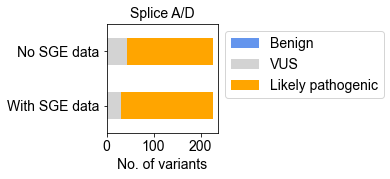

In [33]:
df = pd.read_csv(out_files+'Splice_site_denovo_classification_change_w_SGE.txt', '\t')    
# plot a Stacked Bar Chart using matplotlib

plt.rcParams["figure.figsize"] = (2,2)
df.plot(
    x = 'SGE',
    kind = 'barh',
    stacked = True,
    title = 'Stacked Bar Graph',
    color=['cornflowerblue','lightgrey', 'orange'], mark_right = True)

plt.title('Splice A/D', fontsize=14)
plt.legend(bbox_to_anchor=(1, 1), fontsize=14)
plt.xlabel('No. of variants', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('')
plt.savefig(out_files+'/Splice_site_denovo_classification_no_SGE.pdf', dpi=1300, bbox_inches='tight', transparent=True)
plt.show()

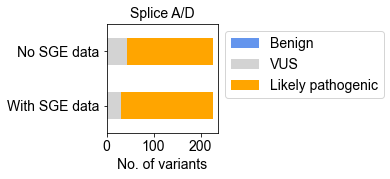

scp er10@gen3-head1://nfs/users/nfs_e/er10/SGE/data/Release_4/Figure_plots/Fig4B_spliceAD_not_denovo_classification_no_SGE.pdf /Users/er10/Documents/Results/SGE_data/Release_4/Figure_plots/Fig4B_spliceAD_not_denovo_classification_impact_SGE.pdf


In [34]:
df = pd.read_csv(out_files+'Splice_site_not_denovo_classification_change_w_SGE.txt', '\t')    
# plot a Stacked Bar Chart using matplotlib

plt.rcParams["figure.figsize"] = (2,2)
df.plot(
    x = 'SGE',
    kind = 'barh',
    stacked = True,
    title = 'Stacked Bar Graph',
    color=['cornflowerblue','lightgrey', 'orange'], mark_right = True)

plt.title('Splice A/D', fontsize=14)
plt.legend(bbox_to_anchor=(1, 1), fontsize=14)
plt.xlabel('No. of variants', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('')
plt.savefig(out_files+'/Fig6C_spliceAD_not_denovo_classification_no_SGE.pdf', dpi=1300, bbox_inches='tight', transparent=True)
plt.show()


/nfs/users/nfs_e/er10/.local/lib/python3.9/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


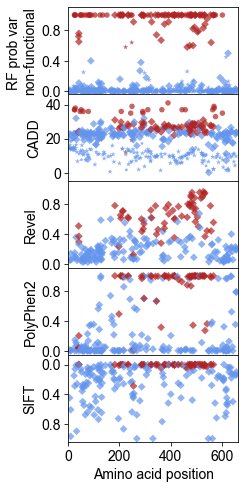

In [23]:
import matplotlib
formatter = mpl.ticker.FormatStrFormatter('%d')


coding_true_pos_neg = true_pos_neg.query('Simplified_protein_pos != "-"')
coding_true_pos_neg[["Simplified_protein_pos"]] = coding_true_pos_neg[["Simplified_protein_pos"]].apply(pd.to_numeric)
missense_true_pos_neg=coding_true_pos_neg.query('PolyPhen_numeric != "NaN" and SIFT_numeric != "NaN" and revel != "No_revel_score"')
missense_true_pos_neg.astype({'PolyPhen_numeric': 'float64', 'Simplified_protein_pos': 'int64', 'SIFT_numeric': 'float64'})
missense_true_pos_neg[["PolyPhen_numeric"]] = missense_true_pos_neg[["PolyPhen_numeric"]].apply(pd.to_numeric)
missense_true_pos_neg[["SIFT_numeric"]] = missense_true_pos_neg[["SIFT_numeric"]].apply(pd.to_numeric)
missense_true_pos_neg[["revel"]] = missense_true_pos_neg[["revel"]].apply(pd.to_numeric)

color_dict = dict({'GnomAD/UKBB/Benign':'cornflowerblue', 'LP/P Female denovo':'firebrick'})

fig = plt.figure(figsize=(8,8))
gs = matplotlib.gridspec.GridSpec(nrows=5, 
                       ncols=5, 
                       figure=fig, 
                       width_ratios= [1,1,1,1,1],
                       height_ratios=[1,1,1,1,1],
                       wspace=0.2,
                       hspace=0.00)

ax1 = fig.add_subplot(gs[0, 0:2])
ax1.set_xlim(0,663)
ax1.set_ylim(-0.04,1.1)
loc = mpl.ticker.MultipleLocator(base=0.4) # this locator puts ticks at regular intervals
ax1.yaxis.set_major_locator(loc)
ax1.set_ylabel('RF prob var \nnon-functional', fontsize=14)
ax1.tick_params(axis='y', length=4, labelsize=14)
ax1.tick_params(axis='x', length=0)
sns.scatterplot(x="Simplified_protein_pos", y="Posterior_probability_variant_is_functionally_abnormal_of_NDD_relevance",
                hue="True_pos_neg", style="Variant_category", markers={'nonsense':'o', 'missense':'D', 'splice A/D':'s', 'inframe':'P', 'synonymous':'*', 'noncoding':'.'}, alpha=0.7, 
                  palette = color_dict, marker='o', s=30, edgecolor='none', 
                data=coding_true_pos_neg, ax=ax1, legend=False)
ax1.set(xlabel=None, xticklabels=[])



ax2 = fig.add_subplot(gs[1, 0:2])
g=sns.scatterplot(x="Simplified_protein_pos", y="CADD_PHRED",
                hue="True_pos_neg", hue_order=['GnomAD/UKBB/Benign','LP/P Female denovo'], style="Variant_category", markers={'nonsense':'o', 'missense':'D', 'splice A/D':'s', 'inframe':'P', 'synonymous':'*', 'noncoding':'.'}, alpha=0.7, 
                  palette = color_dict, marker='o', s=30, edgecolor='none', 
                data=coding_true_pos_neg, ax=ax2, legend=False)
ax2.set_xlim(0,663)
ax2.set_ylim(-5,46)
loc = mpl.ticker.MultipleLocator(base=20) # this locator puts ticks at regular intervals
ax2.yaxis.set_major_locator(loc)
ax2.set_ylabel('CADD', fontsize=14)
ax2.tick_params(axis='y', length=4, labelsize=14)
ax2.set(xlabel=None, xticklabels=[])
plt.legend([],[], frameon=False)

ax3 = fig.add_subplot(gs[2, 0:2])
sns.scatterplot(x="Simplified_protein_pos", y="revel",
                hue="True_pos_neg", style="Variant_category", markers={'nonsense':'o', 'missense':'D', 'splice A/D':'s', 'inframe':'P', 'synonymous':'*', 'noncoding':'.'}, alpha=0.7, 
                  palette = color_dict, marker='o',s=30, edgecolor='none', 
                data=missense_true_pos_neg, ax=ax3, legend=False)
ax3.set_xlim(0,663)
ax3.set_ylim(-0.06,1.1)
ax3.tick_params(axis='x', length=0)
ax3.set(xlabel=None, xticklabels=[])
loc = mpl.ticker.MultipleLocator(base=0.4) # this locator puts ticks at regular intervals
ax3.yaxis.set_major_locator(loc)
ax3.set_ylabel('Revel', fontsize=14)
ax3.tick_params(axis='y', length=4, labelsize=14)

ax4 = fig.add_subplot(gs[3, 0:2])
sns.scatterplot(x="Simplified_protein_pos", y="PolyPhen_numeric",
                hue="True_pos_neg", style="Variant_category", markers={'nonsense':'o', 'missense':'D', 'splice A/D':'s', 'inframe':'P', 'synonymous':'*', 'noncoding':'.'}, alpha=0.7, 
                  palette = color_dict, marker='o', s=30, edgecolor='none', 
                data=missense_true_pos_neg, ax=ax4, legend=False)
ax4.set_xlim(0,663)
ax4.set_ylim(-0.06,1.1)
ax4.tick_params(axis='x', length=0)
ax4.set(xlabel=None, xticklabels=[])
loc = mpl.ticker.MultipleLocator(base=0.4) # this locator puts ticks at regular intervals
ax4.yaxis.set_major_locator(loc)
ax4.set_ylabel('PolyPhen2', fontsize=14)
ax4.tick_params(axis='y', length=4, labelsize=14)
plt.legend([],[], frameon=False)
 
ax5 = fig.add_subplot(gs[4, 0:2])
sns.scatterplot(x="Simplified_protein_pos", y="SIFT_numeric",
                hue="True_pos_neg", style="Variant_category", markers={'nonsense':'o', 'missense':'D', 'splice A/D':'s', 'inframe':'P', 'synonymous':'*', 'noncoding':'.'}, 
                  palette = color_dict, s=30, edgecolor='none', linewidth=0.2,  data=missense_true_pos_neg, ax=ax5, 
                legend=False, alpha=0.7)
ax5.set_xlim(0,663)
ax5.set_ylim(-0.125,1.05)
ax5.tick_params(axis='x', length=4)
loc = mpl.ticker.MultipleLocator(base=0.4) # this locator puts ticks at regular intervals
ax5.yaxis.set_major_locator(loc)
ax5.set_ylabel('SIFT', fontsize=14)
ax5.invert_yaxis()
ax5.tick_params(axis='y', length=4, labelsize=14)
ax5.tick_params(axis='x', length=4, labelsize=14)
ax5.set_xlabel('Amino acid position', fontsize=14)
plt.legend([],[], frameon=False)

plt.savefig(out_files+'//Fig6d_VEP_over_protein.pdf', dpi=1300, bbox_inches='tight', transparent = True)
plt.show()



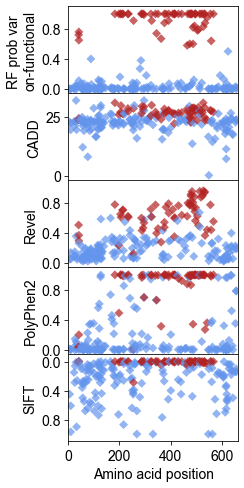

In [24]:
import matplotlib
formatter = mpl.ticker.FormatStrFormatter('%d')

color_dict = dict({'GnomAD/UKBB/Benign':'cornflowerblue', 'LP/P Female denovo':'firebrick'})

fig = plt.figure(figsize=(8,8))
gs = matplotlib.gridspec.GridSpec(nrows=5, 
                       ncols=5, 
                       figure=fig, 
                       width_ratios= [1,1,1,1,1],
                       height_ratios=[1,1,1,1,1],
                       wspace=0.2,
                       hspace=0.00)
ax1 = fig.add_subplot(gs[0, 0:2])
ax1.set_xlim(0,663)
ax1.set_ylim(-0.06,1.1)
ax1.set_ylabel('RF prob var \non-functional', fontsize=14)
ax1.tick_params(axis='y', length=4, labelsize=14)
ax1.tick_params(axis='x', length=0)
sns.scatterplot(x="Simplified_protein_pos", y="Posterior_probability_variant_is_functionally_abnormal_of_NDD_relevance",
                hue="True_pos_neg", style="Variant_category", markers={'nonsense':'o', 'missense':'D', 'splice A/D':'s', 'inframe':'P', 'synonymous':'*', 'noncoding':'.'}, alpha=0.7, 
                  palette = color_dict, marker='o', s=40, edgecolor='none', 
                data=missense_true_pos_neg, ax=ax1, legend=False)
ax1.set(xlabel=None, xticklabels=[])
loc = mpl.ticker.MultipleLocator(base=0.4) # this locator puts ticks at regular intervals
ax1.yaxis.set_major_locator(loc)

ax2 = fig.add_subplot(gs[1, 0:2])
sns.scatterplot(x="Simplified_protein_pos", y="CADD_PHRED",
                hue="True_pos_neg", style="Variant_category", markers={'nonsense':'o', 'missense':'D', 'splice A/D':'s', 'inframe':'P', 'synonymous':'*', 'noncoding':'.'}, alpha=0.7, 
                  palette = color_dict, marker='o', s=40, edgecolor='none', 
                data=missense_true_pos_neg, ax=ax2, legend=False)
ax2.set_xlim(0,663)
ax2.set_ylim(-2,35)
ax2.tick_params(axis='x', length=0)
ax2.set(xlabel=None, xticklabels=[])
loc = mpl.ticker.MultipleLocator(base=25) # this locator puts ticks at regular intervals
ax2.yaxis.set_major_locator(loc)
ax2.set_ylabel('CADD', fontsize=14)
ax2.tick_params(axis='y', length=4, labelsize=14)

ax3 = fig.add_subplot(gs[2, 0:2])
sns.scatterplot(x="Simplified_protein_pos", y="revel",
                hue="True_pos_neg", style="Variant_category", markers={'nonsense':'o', 'missense':'D', 'splice A/D':'s', 'inframe':'P', 'synonymous':'*', 'noncoding':'.'}, alpha=0.7, 
                  palette = color_dict, marker='o', s=40, edgecolor='none', 
                data=missense_true_pos_neg, ax=ax3, legend=False)
ax3.set_xlim(0,663)
ax3.set_ylim(-0.06,1.1)
ax3.tick_params(axis='x', length=0)
ax3.set(xlabel=None, xticklabels=[])
loc = mpl.ticker.MultipleLocator(base=0.4) # this locator puts ticks at regular intervals
ax3.yaxis.set_major_locator(loc)
ax3.set_ylabel('Revel', fontsize=14)
ax3.tick_params(axis='y', length=4, labelsize=14)

ax4 = fig.add_subplot(gs[3, 0:2])
sns.scatterplot(x="Simplified_protein_pos", y="PolyPhen_numeric",
                hue="True_pos_neg", style="Variant_category", markers={'nonsense':'o', 'missense':'D', 'splice A/D':'s', 'inframe':'P', 'synonymous':'*', 'noncoding':'.'}, alpha=0.7, 
                  palette = color_dict, marker='o', s=40, edgecolor='none', 
                data=missense_true_pos_neg, ax=ax4, legend=False)
ax4.set_xlim(0,663)
ax4.set_ylim(-0.06,1.1)
ax4.tick_params(axis='x', length=0)
ax4.set(xlabel=None, xticklabels=[])
loc = mpl.ticker.MultipleLocator(base=0.4) # this locator puts ticks at regular intervals
ax4.yaxis.set_major_locator(loc)
ax4.set_ylabel('PolyPhen2', fontsize=14)
ax4.tick_params(axis='y', length=4, labelsize=14)

ax5 = fig.add_subplot(gs[4, 0:2])
sns.scatterplot(x="Simplified_protein_pos", y="SIFT_numeric",
                hue="True_pos_neg", style="Variant_category", markers={'nonsense':'o', 'missense':'D', 'splice A/D':'s', 'inframe':'P', 'synonymous':'*', 'noncoding':'.'}, alpha=0.7, 
                  palette = color_dict, marker='o', s=40, edgecolor='none', 
                data=missense_true_pos_neg, ax=ax5, legend=False)

ax5.set_ylim(-0.1,1.1)
ax5.tick_params(axis='x', length=4)
loc = mpl.ticker.MultipleLocator(base=0.4) # this locator puts ticks at regular intervals
ax5.yaxis.set_major_locator(loc)
ax5.set_ylabel('SIFT', fontsize=14)
ax5.invert_yaxis()
ax5.tick_params(axis='y', length=4, labelsize=14)
ax5.tick_params(axis='x', length=4, labelsize=14)
ax5.set_xlim(0,663)
loc = mpl.ticker.MultipleLocator(base=200) # this locator puts ticks at regular intervals
ax5.xaxis.set_major_locator(loc)
ax5.set_xlabel('Amino acid position', fontsize=14)
plt.legend([],[], frameon=False)

plt.savefig(out_files+'/Fig6e_missense_VEP_over_protein.pdf', dpi=1300, bbox_inches='tight', transparent = True)
plt.show()


